In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

from typing import Callable
from functools import partial

import jax
import jax.numpy as jnp
import optax

from jax import Array
from jax import vmap, value_and_grad, jit, grad
from jax import random

from bpd.pipelines.image_samples import loglikelihood, logprior, logtarget, sample_target_galaxy_params_simple, get_target_images, get_true_params_from_galaxy_params
from bpd.draw import draw_gaussian

import matplotlib.pyplot as plt

2024-12-04 11:11:52.765465: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-12-04 11:11:59.594455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def sample_prior(
    rng_key,
    *,
    flux_bds: tuple = (2.5, 4.0),
    hlr_bds: tuple = (0.7, 2.0),
    shape_noise: float = 0.3,
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2, k3 = random.split(rng_key, 3)

    lf = random.uniform(k1, minval=flux_bds[0], maxval=flux_bds[1])
    hlr = random.uniform(k2, minval=hlr_bds[0], maxval=hlr_bds[1])

    other_params = sample_target_galaxy_params_simple(
        k3, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": hlr, **other_params}

def _sample_prior_init(rng_key):
    prior_samples = sample_prior(rng_key)
    truth_samples = get_true_params_from_galaxy_params(prior_samples)
    return truth_samples

In [3]:
def find_likelihood_peak(
    data: Array,
    params_init:dict,
    *,
    learning_rate: float = 1e-3,
    n_steps: int = 1000,
    likelihood_fnc: Callable,
) -> tuple[float, float]:
    """Find the peak of the likelihood using gradient descent."""

    def loss(params):
        return -likelihood_fnc(params, data)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params_init)
    vals = [] 
    params = params_init

    @jit
    def step(params, opt_state):
        loss_val, grads = value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val

    for _ in range(n_steps):
        params, opt_state, loss_val = step(params, opt_state)
        vals.append(loss_val)

    return params, jnp.array(vals)

In [4]:
def find_likelihood_peak_scan(
    data: Array,
    params_init:dict,
    *,
    learning_rate: float = 1e-3,
    n_steps: int = 1000,
    likelihood_fnc: Callable,
) -> tuple[float, float]:
    """Find the peak of the likelihood using gradient descent."""

    def loss(params):
        return -likelihood_fnc(params, data)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params_init)
    vals = [] 
    params = params_init

    def step(state, _):
        params, opt_state = state
        loss_val, grads = value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss_val


    (params, _), loss_vals = jax.lax.scan(step, (params, opt_state), length=n_steps)



    return params, loss_vals

In [5]:
# def find_likelihood_peak_lbfgs(
#     data: Array,
#     params_init:dict,
#     *,
#     learning_rate: float = 1e-3,
#     n_steps: int = 1000,
#     likelihood_fnc: Callable,
# ) -> tuple[float, float]:
#     """Find the peak of the likelihood using gradient descent."""

#     def loss(params):
#         return -likelihood_fnc(params, data)

#     optimizer = optax.lbfgs(learning_rate)
#     opt_state = optimizer.init(params_init)
#     _value_and_grad = optax.value_and_grad_from_state(loss)

#     @jit
#     def step(params, opt_state):
#         vals, grads = _value_and_grad(params, state=opt_state)
#         updates, opt_state = optimizer.update(grads, opt_state, params,value=vals, grad=grads,value_fn=loss)
#         params = optax.apply_updates(params, updates)
#         return params, opt_state, vals

#     for _ in range(n_steps):
#         params, opt_state, _ = step(params_init, opt_state)

#     return params

## Test optimization

In [102]:
rng_key = random.key(42)
pkey, nkey, ikey, rkey = random.split(rng_key, 4)

n_gals = 100
shape_noise = 0.3
background= 1.
slen = 53
fft_size=256


In [103]:
# generate data and parameters
pkeys = random.split(pkey, n_gals)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(pkeys)
assert galaxy_params["x"].shape == (n_gals,)

# get images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)

In [104]:
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(loglikelihood, draw_fnc=draw_fnc, background=background)

In [105]:
init_params = _sample_prior_init(ikey)
init_params['lf'] = jnp.log10(target_images[3].sum())
init_params['lf']

Array(3.82110866, dtype=float64)

In [106]:
%time fparams, vals = find_likelihood_peak_scan(target_images[3], init_params, likelihood_fnc=_loglikelihood,learning_rate=1e-3, n_steps=2500)

CPU times: user 2.25 s, sys: 286 ms, total: 2.54 s
Wall time: 2.73 s


In [107]:
fparams

{'e1': Array(0.08769677, dtype=float64),
 'e2': Array(-0.0866866, dtype=float64),
 'hlr': Array(1.57712345, dtype=float64),
 'lf': Array(3.81945137, dtype=float64),
 'x': Array(0.44531078, dtype=float64),
 'y': Array(-0.3355329, dtype=float64)}

In [108]:
{p:q[3] for p,q in true_params.items()}

{'e1': Array(0.08341272, dtype=float64),
 'e2': Array(-0.08991952, dtype=float64),
 'hlr': Array(1.57344803, dtype=float64),
 'lf': Array(3.82071287, dtype=float64),
 'x': Array(0.39980168, dtype=float64),
 'y': Array(-0.30789742, dtype=float64)}

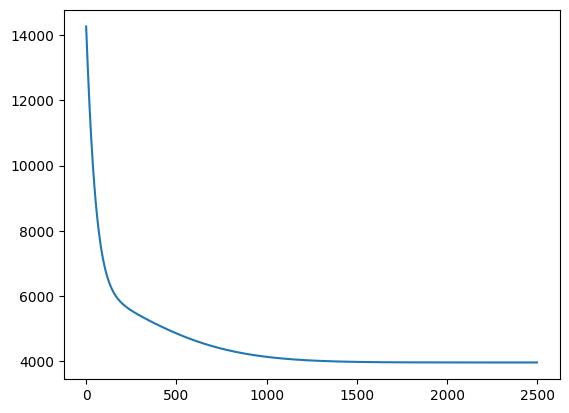

In [109]:
plt.plot(vals)

In [116]:
# vmap? 
init_params = {'lf': jnp.log10(target_images.sum(axis=(1,2))), 'hlr': jnp.full((n_gals,), 1.0), 
               'x':jnp.zeros(n_gals), 'y':jnp.zeros(n_gals), 'e1':jnp.zeros(n_gals), 'e2':jnp.zeros(n_gals)
               }


get_mle = jax.jit(partial(find_likelihood_peak_scan, likelihood_fnc=_loglikelihood, learning_rate=1e-3, n_steps=1000))


In [117]:
%time _ = get_mle(target_images[0], {p: q[0] for p,q in init_params.items()})

CPU times: user 1.4 s, sys: 192 ms, total: 1.59 s
Wall time: 1.8 s


In [118]:
# make sure gpu
init_params = jax.device_put(init_params, jax.devices()[0])
target_images = jax.device_put(target_images, jax.devices()[0])

In [119]:
%time params, valss = vmap(get_mle)(target_images, init_params)

CPU times: user 5.14 s, sys: 32.4 ms, total: 5.17 s
Wall time: 5.47 s


In [126]:
idx = 10
{p:q[idx] for p,q in params.items()}, {k:v[idx] for k,v in true_params.items()}

({'e1': Array(0.01436915, dtype=float64),
  'e2': Array(0.03079787, dtype=float64),
  'hlr': Array(0.94277652, dtype=float64),
  'lf': Array(3.29679319, dtype=float64),
  'x': Array(0.18520168, dtype=float64),
  'y': Array(0.24368989, dtype=float64)},
 {'e1': Array(0.02217556, dtype=float64),
  'e2': Array(-0.00136225, dtype=float64),
  'hlr': Array(0.97781089, dtype=float64),
  'lf': Array(3.30683402, dtype=float64),
  'x': Array(0.13246106, dtype=float64),
  'y': Array(0.16570657, dtype=float64)})

# Try chains with this initialization strategy, then check step size!

In [25]:
rng_key = random.key(42)
pkey, nkey, ikey, rkey = random.split(rng_key, 4)

n_gals = 10
shape_noise = 0.3
background= 1.
slen = 53
fft_size=256
sigma_e_int=0.4


In [26]:
# generate data and parameters
pkeys = random.split(pkey, n_gals)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(pkeys)
assert galaxy_params["x"].shape == (n_gals,)

# get images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)

In [27]:
# setup target density
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(loglikelihood, draw_fnc=draw_fnc, background=background)
_logprior = partial(logprior, sigma_e=sigma_e_int)
_logtarget = partial(
    logtarget, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)


In [28]:
# init params
# vmap? 
default_params = {'lf': jnp.log10(target_images.sum(axis=(1,2))), 'hlr': jnp.full((n_gals,), 1.0), 
               'x':jnp.zeros(n_gals), 'y':jnp.zeros(n_gals), 'e1':jnp.zeros(n_gals), 'e2':jnp.zeros(n_gals)
               }


get_mle = jax.jit(partial(find_likelihood_peak_scan, likelihood_fnc=_loglikelihood, learning_rate=1e-3, n_steps=1000))
%time _ = get_mle(target_images[0], {p: q[0] for p,q in default_params.items()}) # compile
%time init_params, _ = vmap(get_mle)(target_images, default_params)


CPU times: user 1.43 s, sys: 170 ms, total: 1.6 s
Wall time: 1.82 s
CPU times: user 1.95 s, sys: 30.1 ms, total: 1.98 s
Wall time: 2.23 s


In [142]:
# warmup 
from bpd.chains import run_sampling_nuts, run_warmup_nuts

_run_warmup1 = partial(
    run_warmup_nuts,
    logtarget=_logtarget,
    initial_step_size=0.45,
    max_num_doublings=4,
    n_warmup_steps=250,
)
_run_warmup = vmap(vmap(jit(_run_warmup1), in_axes=(0, None, None)))

In [143]:
_run_sampling1 = partial(
    run_sampling_nuts,
    logtarget=_logtarget,
    n_samples=500,
    max_num_doublings=3,
)
_run_sampling = vmap(vmap(jit(_run_sampling1), in_axes=(0, 0, 0, None)))

In [144]:
gkeys = random.split(rkey, (n_gals, 4, 2))
wkeys = gkeys[..., 0]
ikeys = gkeys[..., 1]

In [ ]:
# compile
_ = _run_warmup(
    wkeys[0, None], {p:q[0, None] for p,q in init_params.items()}, target_images[0, None]
)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f8617a34790>
Traceback (most recent call last):
  File "/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


In [ ]:
%time new_states, tuned_params, adapt_info = _run_warmup(wkeys, init_params, target_images)

In [124]:
new_states.position['e1'].shape

(10, 4)

In [125]:
my_tuned_params = {p:q for p,q in tuned_params.items() if p!='max_num_doublings'}

In [128]:
samples, _ = _run_sampling(
    ikeys, new_states, my_tuned_params, target_images
)

In [129]:
%time samples, _ = _run_sampling(ikeys, new_states, my_tuned_params, target_images)

CPU times: user 5.61 s, sys: 7.77 ms, total: 5.61 s
Wall time: 5.61 s


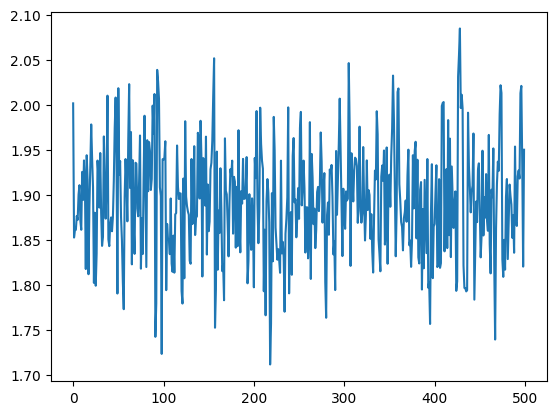

In [130]:
plt.plot(samples['hlr'][0, 0, :])

In [131]:
from blackjax.diagnostics import effective_sample_size

In [140]:
ess = []
p = 'x'
for ii in range(n_gals):
    ess.append(effective_sample_size(samples[p][ii]) / 2000)
    
    

In [141]:
ess

[Array(0.95634127, dtype=float64),
 Array(0.66791023, dtype=float64),
 Array(0.47535998, dtype=float64),
 Array(1.05289563, dtype=float64),
 Array(0.0305371, dtype=float64),
 Array(0.58980109, dtype=float64),
 Array(0.92114123, dtype=float64),
 Array(0.67116043, dtype=float64),
 Array(0.63171563, dtype=float64),
 Array(0.5671219, dtype=float64)]